In [ ]:
import torch
import pandas as pd
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import re
from nltk.stem import WordNetLemmatizer, PorterStemmer
import nltk, csv, string, random, os, pickle
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

ENGLISH_STOPWORDS = stopwords.words('english')
PUNCTUATIONS = string.punctuation
LEMMATIZER = WordNetLemmatizer()
STEMMER = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
model = RobertaForSequenceClassification.from_pretrained('roberta-base', cache_dir="./roberta_cache")
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base', cache_dir="./roberta_cache")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
dataset = pd.read_csv('https://drive.google.com/uc?export=download&id=1usrq7Gl3iVngx4-IbbczLl1dyK38JeOC')
dataset.dropna()
dataset.head()

,label,comment
0,1,Yes that's why I don't advocate for the rights...
1,1,I can find you a Pinsir if you want one that bad.
2,0,"Huh, that's pretty interesting actually thanks..."
3,1,TIL a monsoon = average summer weather in Sweden
4,1,Yeah everyone knows holographic tigers and bom...


In [ ]:
max_length = 100
tokenized_texts = [tokenizer.encode(str(text), add_special_tokens=True, max_length=max_length, truncation=True, padding='max_length') for text in dataset['comment']]
input_ids = torch.tensor(tokenized_texts)
labels = torch.tensor(dataset['label'].values)

In [ ]:
train_inputs, test_inputs, train_labels, test_labels = train_test_split(input_ids, labels, test_size=0.2, random_state=42)
train_masks = (train_inputs != tokenizer.pad_token_id).type(torch.float32)
test_masks = (test_inputs != tokenizer.pad_token_id).type(torch.float32)

In [ ]:
batch_size = 64
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 11
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = tuple(t.to(device) for t in batch)
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss}")

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/11, Loss: 360.36193707585335
Epoch 2/11, Loss: 310.856576949358
Epoch 3/11, Loss: 265.5049233287573
Epoch 4/11, Loss: 216.52032764256
Epoch 5/11, Loss: 163.31502881646156
Epoch 6/11, Loss: 120.70973285660148
Epoch 7/11, Loss: 92.4924850743264
Epoch 8/11, Loss: 70.59645586367697
Epoch 9/11, Loss: 58.20143542252481
Epoch 10/11, Loss: 49.75912765227258
Epoch 11/11, Loss: 42.04995759436861


In [ ]:
model.eval()
predictions = []
true_labels = []
for batch in test_loader:
    batch = tuple(t.to(device) for t in batch)
    inputs, masks, labels = batch
    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)
    logits = outputs.logits
    predicted_labels = torch.argmax(logits, dim=1).cpu().numpy()
    predictions.extend(predicted_labels)
    true_labels.extend(labels.cpu().numpy())

In [ ]:
accuracy = accuracy_score(true_labels, predictions)
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.7342


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

           0       0.74      0.72      0.73      4984
           1       0.73      0.75      0.74      5016

    accuracy                           0.73     10000
   macro avg       0.73      0.73      0.73     10000
weighted avg       0.73      0.73      0.73     10000



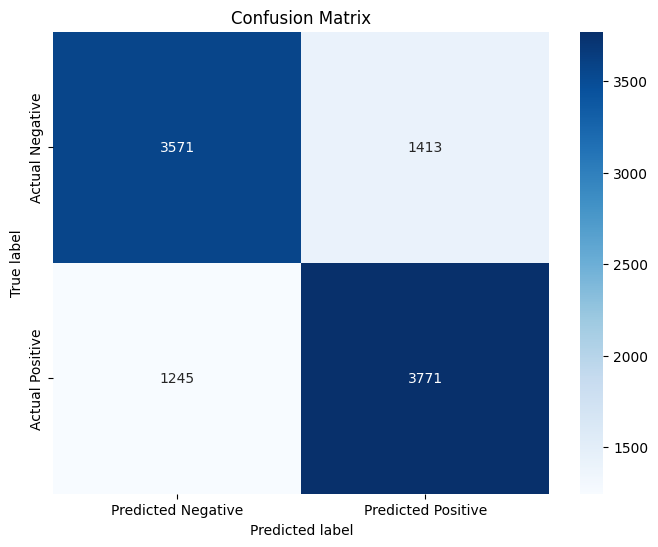

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
predict  = pd.DataFrame(predictions)
ytest = pd.DataFrame(true_labels)

In [ ]:
predict.to_csv('predict_RoBERTa50k.csv', index=False)

In [ ]:
ytest.to_csv('y_true_RoBERTa50k.csv', index=False)

In [ ]:
yt = pd.read_csv("y_true_RoBERTa50k.csv")
yp = pd.read_csv("predict_RoBERTa50k.csv")

In [ ]:
print(f"F1 SCORE: {f1_score(yt, yp)}")

F1 SCORE: 0.7394117647058824
